<a href="https://colab.research.google.com/github/Mohammed-AlKuhali/Palm-Fruit-Classification-CNN/blob/main/MohdKuhaliPFRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the initial line, the drive module is imported from the google.colab package. This module enables interaction with Google Drive functionalities within the Colab environment.

#The subsequent line mounts a specific Google Drive folder, identified as "MyDrive/colab2," to the Colab environment. This means that the contents of the "MyDrive/Ms_Wan2" folder, including files and directories, will be accessible and manipulable within the Colab environment under the project_dir variable. This enables easy access and utilization of files stored in that particular Google Drive folder throughout the Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir='/content/drive/MyDrive/colab2'

#The code includes import statements for several libraries and functions that are required for the subsequent script. These libraries and functions include TensorFlow, Numpy, Pandas, and various Keras layers and functions.

#TensorFlow is a popular machine learning framework used for building and training deep learning models. It provides a range of tools and functionalities for implementing neural networks.

#Numpy is a library used for numerical computations in Python. It provides support for mathematical operations on arrays and matrices, making it useful for manipulating and processing numerical data.

#Pandas is a library that offers data manipulation and analysis tools. It provides data structures such as DataFrames, which allow for efficient handling and processing of structured data.

#Keras is a high-level neural network library that runs on top of TensorFlow. It simplifies the process of building and training neural networks by providing a user-friendly API and a wide range of pre-defined layers and functions.

#By importing these libraries and functions, the script can leverage their capabilities for tasks such as data manipulation, neural network construction, and training.

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LSTM,Embedding
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from keras.utils.vis_utils import plot_model
from collections import Counter
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB7
from sklearn.metrics import classification_report, confusion_matrix

#The code defines a constant variable named IMAGE_SHAPE, which is set as a tuple with a height of 128 and a width of 128. This constant represents the desired shape to which all images in the dataset will be resized.

#Resizing images to a consistent shape is a common practice in computer vision tasks, as it ensures uniformity and compatibility across the dataset. By setting the IMAGE_SHAPE constant to (128, 128), it indicates that all images will be transformed or resized to have a height of 128 pixels and a width of 128 pixels. This standardized size simplifies data preprocessing and enables consistent input dimensions for the subsequent steps of the script, such as feeding the images into a neural network model.

#The code defines a constant variable named datagen_kwargs, which is a dictionary containing specific key-value pairs.

#The first key-value pair is 'rescale' with a value of 1/255. This indicates that the image data should be rescaled by a factor of 1/255. Rescaling is a common preprocessing step in image data, where the pixel values are divided by the maximum pixel value (255 in this case) to bring the values within the range of 0 to 1. This normalization helps in improving the model's training efficiency and convergence.

#The second key-value pair is 'validation_split' with a value of 0.2. This specifies that 20% of the data should be allocated for validation during the training process. The data will be randomly split, with 80% used for training and 20% used for validation. This enables the model to be evaluated on unseen data and helps in monitoring its performance and generalization ability.

#The third key-value pair is 'zoom_range' with a value specifying the range for random zooming. In this case, the value indicates that during data augmentation, the images may be randomly zoomed by a factor between 0.5 and 1.0. This augmentation technique introduces slight variations in the data by zooming in or out on the images, enhancing the model's robustness and ability to handle different image scales.

#By defining these values within the datagen_kwargs dictionary, the code specifies the desired configurations for rescaling, validation data split, and zooming during the data augmentation process.

In [ ]:
IMAGE_SHAPE = (128, 128) # (height, width)
datagen_kwargs = dict(rescale=1./255, validation_split=.20,
                      zoom_range=[0.5,1.0])

#The code utilizes the `tf.keras.preprocessing.image.ImageDataGenerator` class to create two image data generators: one for training and one for testing.

#First, the `test_datagen` object is created by passing the `datagen_kwargs` dictionary. This ensures that the test data generator applies the specified configurations such as rescaling, validation data split, and zooming during data augmentation.

#Next, the `test_generator` object is created using the `test_datagen` object and the `flow_from_directory` method. This method enables loading and preprocessing of image data from a specified directory (`project_dir`). By setting the `subset` argument to `'validation'`, the generator will only use the validation data from the specified directory. The `shuffle` argument is set to `True` to randomize the order of the data during training, and the `target_size` argument is set to `IMAGE_SHAPE` to resize the images to the desired shape defined earlier.

#In summary, these steps establish two image data generators: `test_generator` for validation data. These generators will apply the specified preprocessing techniques, load images from the provided directory, and resize them to the desired shape.

In [ ]:
'''Image Data Generators are used to Generate batches of tensor image data with real-time data augmentation.
rotation_range=45,zoom_range=[0.5,1.0] are augmentation techniques
'''

#test
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
project_dir,
subset='validation',
shuffle=True,
target_size=IMAGE_SHAPE
)

#train
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
project_dir,
subset='training',
shuffle=True,
target_size=IMAGE_SHAPE)

Found 133 images belonging to 3 classes.
Found 537 images belonging to 3 classes.


#After creating the `train_generator` object, the code prints the class indices associated with the training data. These indices represent the mapping between class names and numeric labels within the dataset.

#By printing the class indices, you can see the correspondence between each class name and its respective label. This information is helpful for understanding the organization of the dataset and ensuring that the labels are correctly assigned to the corresponding classes during the training process.

#The class indices provide a convenient reference when analyzing the model's predictions or evaluating its performance on specific classes.

In [ ]:
print (train_generator.class_indices)

{'ripe': 0, 'underripe': 1, 'unripe': 2}


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(test_generator.samples/test_generator.batch_size)

#The code defines a function named `con_matrix` that is used to plot a confusion matrix. This function takes two arguments: `y_test`, representing the true labels, and `y_predict`, representing the predicted labels.

#Inside the function, the confusion matrix is calculated using the `confusion_matrix` function from the `sklearn.metrics` module. This function compares the true labels (`y_test`) with the predicted labels (`y_predict`) and generates a matrix that shows the counts of each class being correctly or incorrectly predicted.

#Next, the confusion matrix is normalized by dividing all values by the total number of samples. This normalization provides a relative understanding of the prediction accuracy for each class, even when the classes have imbalanced sample sizes.

#To plot the matrix, the function utilizes the `seaborn` library, which provides an interface for creating visually appealing statistical graphics. The resulting confusion matrix is displayed using the `matplotlib` library, which is a widely used plotting library in Python.

#By using this `con_matrix` function, you can generate and visualize the confusion matrix to gain insights into the model's performance and identify any patterns of misclassification across different classes.

In [ ]:
def con_matrix(y_test,y_predict):
    cm=confusion_matrix(y_test,y_predict,normalize="true")*100
    plt.figure(figsize=(10,10))
    df=pd.DataFrame(cm)
    sn.heatmap(df,annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

#The code you provided defines a function named `f1_metric` that calculates the F1 score metric for evaluating a classification model's performance. This function takes in two arguments: `y_true`, representing the true labels, and `y_pred`, representing the predicted labels.

#Inside the function, the F1 score is computed using the following steps:

#1. `true_positives` are calculated as the sum of the element-wise multiplication between the rounded predictions (`y_pred`) and the true labels (`y_true`), with values clipped between 0 and 1.

#2. `possible_positives` are calculated as the sum of the rounded true labels (`y_true`), with values clipped between 0 and 1.

#3. `predicted_positives` are calculated as the sum of the rounded predictions (`y_pred`), with values clipped between 0 and 1.

#4. `precision` is computed by dividing `true_positives` by the sum of `predicted_positives` and a small epsilon value (`K.epsilon()`) to avoid division by zero.

#5. `recall` is computed by dividing `true_positives` by the sum of `possible_positives` and `K.epsilon()`.

#6. `f1_val` is calculated using the formula 2 * (precision * recall) / (precision + recall + `K.epsilon()`).

#7. Finally, the function returns the computed `f1_val`, which represents the F1 score.

#The F1 score is a measure that combines precision and recall, providing a balanced evaluation of a model's accuracy. It is commonly used in binary classification tasks, where precision represents the ability to correctly predict positive samples, recall represents the ability to identify all positive samples, and the F1 score combines these two metrics into a single value.

In [ ]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#The code loads the Xception model using the `Xception` function from the `tf.keras.applications` module. The `weights` argument is set to `'imagenet'`, indicating that the model should be initialized with pre-trained weights obtained from training on the ImageNet dataset.

#By setting `include_top` to `False`, the fully-connected layer at the top of the Xception model is excluded. This allows you to customize the model by adding your own layers or modifying the architecture according to your specific needs.

#The `input_shape` argument is set to `(128, 128, 3)` to specify the shape of the input images that the Xception model expects. In this case, the model assumes input images with a height and width of 128 pixels and three color channels (RGB).

#By loading the Xception model with pre-trained weights and excluding the top layer, you can leverage the powerful feature extraction capabilities of the Xception architecture while customizing the model for your specific task or dataset.

In [ ]:
model=Xception(weights="imagenet", include_top=False, input_shape=(128,128,3)) #you can give your model here
model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


#The code provided involves the following steps:
#1. The model's layers are set to be non-trainable by setting the `trainable` attribute to `False`. This ensures that the pre-trained weights of the Xception model are frozen and not updated during the training process.
#2. An input tensor is created using the `Input` function from the `tf.keras.layers` module, with its shape set to `(128, 128, 3)` to match the shape of the input images. This defines the input layer of the subsequent model architecture.
#3. The input tensor is passed through the Xception model, and the output is stored in the variable `x`. This means the input data flows through the layers of the Xception model, utilizing its feature extraction capabilities. The Xception model's layers are also set to be non-trainable, maintaining their pre-trained weights.
#4. A batch normalization layer is added on top of the Xception model's output. Batch normalization helps in normalizing the output from the previous layer, improving the stability and speed of training.
#5. A flatten layer is added to transform the output of the previous layer into a 1-dimensional vector. This flattening step is necessary to connect the output to fully connected (dense) layers.
#6. A dense layer with a sigmoid activation function is added on top. This dense layer performs binary classification, with a sigmoid activation function ensuring the output is within the range of 0 to 1. This is suitable for binary classification problems where the output value represents the probability of belonging to a particular class.
#7. A dense layer with a ReLU activation function is added on top of the flatten layer. This additional dense layer introduces non-linearity to the model and serves as a final classification layer. The ReLU activation function is commonly used in hidden layers to introduce non-linearities and capture complex patterns in the data.
#These steps describe the construction of a model architecture that utilizes the pre-trained Xception model for feature extraction and adds additional layers for classification.

In [ ]:
#add few layers to the base layer in order to match with our data set
input = tf.keras.Input(shape=(128,128,3))
x = tf.keras.applications.xception.Xception(
    input_tensor=input,
    include_top=False,
    weights='imagenet'
)

x.trainable = False
x = tf.keras.layers.BatchNormalization()(x.output)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model_final = Model(input,output)

# model description
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

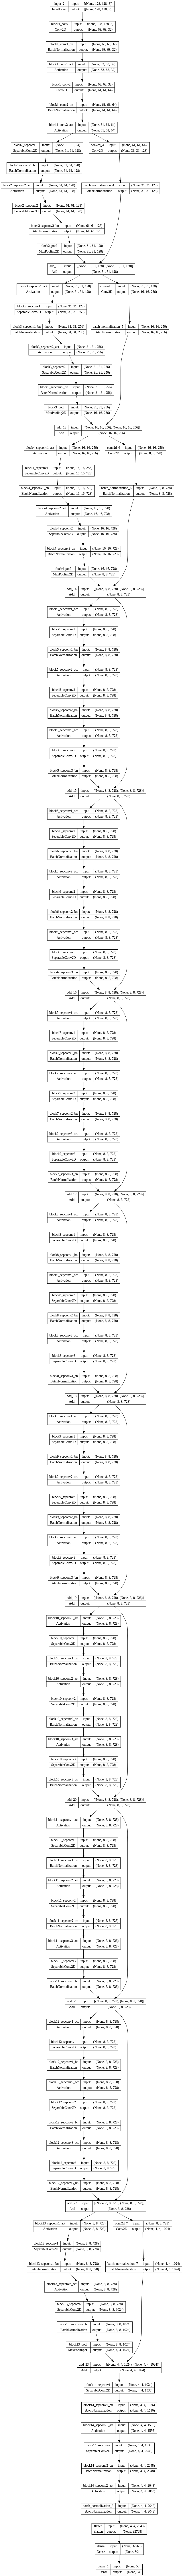

In [ ]:
plot_model(model_final,expand_nested=False, to_file=project_dir+'CNN_model_plot.png', show_shapes=True, show_layer_names=True)

# The model is compiled using the compile method and the Adam optimizer and the binary cross-entropy loss function.

In [ ]:
# Compile
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
			loss='categorical_crossentropy',
			metrics=['accuracy', f1_metric])


#The model is trained using the `fit_generator` method, which trains the model using the data generated by the `train_generator` and `test_generator` objects.

#The `steps_per_epoch` variable determines the number of steps (batches of data) to use for each epoch of training. It controls how many times the model will update its weights based on the data from the `train_generator`. Similarly, the `val_steps_per_epoch` variable specifies the number of steps for each validation epoch, which determines how many batches of data will be used for validation.

#The `epochs` argument indicates the total number of training epochs, representing the number of times the model will iterate through the entire training dataset. During each epoch, the model updates its weights to improve its performance.

#The `validation_split` argument specifies the fraction of the training data that should be set aside for validation. For example, if `validation_split` is set to 0.2, it means that 20% of the training data will be used for validation, while the remaining 80% will be used for training.

#By utilizing the `fit_generator` method with appropriate configurations, the model is trained using the generated data from the `train_generator` and `test_generator` objects, allowing for effective training and evaluation of the model's performance.

In [ ]:
# train the model
history = model_final.fit(train_generator,
 epochs=150,
 batch_size=32,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=test_generator,
 validation_steps=val_steps_per_epoch)


Epoch 1/150
17/17 [==============================] - 189s 11s/step - loss: 1.0921 - accuracy: 0.4637 - f1_metric: 0.3912 - val_loss: 0.8599 - val_accuracy: 0.6541 - val_f1_metric: 0.4925
Epoch 2/150
17/17 [==============================] - 39s 2s/step - loss: 0.7370 - accuracy: 0.6760 - f1_metric: 0.6526 - val_loss: 0.7299 - val_accuracy: 0.7594 - val_f1_metric: 0.6860
Epoch 3/150
17/17 [==============================] - 38s 2s/step - loss: 0.6252 - accuracy: 0.7318 - f1_metric: 0.7269 - val_loss: 0.7015 - val_accuracy: 0.7293 - val_f1_metric: 0.6019
Epoch 4/150
17/17 [==============================] - 37s 2s/step - loss: 0.5672 - accuracy: 0.7579 - f1_metric: 0.7580 - val_loss: 0.6631 - val_accuracy: 0.7519 - val_f1_metric: 0.6814
Epoch 5/150
17/17 [==============================] - 38s 2s/step - loss: 0.4930 - accuracy: 0.8101 - f1_metric: 0.8037 - val_loss: 0.5841 - val_accuracy: 0.7594 - val_f1_metric: 0.7732
Epoch 6/150
17/17 [==============================] - 39s 2s/step - loss: 

In [ ]:
model_final.save_weights(project_dir+'best.h5')
model_final.save(project_dir+'best.h5')

In [ ]:
model_final.load_weights(project_dir+'best.h5')

# This code uses the plt.plot and plt.legend functions from the matplotlib library to plot the model's accuracy and loss on the training and validation sets. The history.history attribute is a dictionary with keys 'accuracy', 'val_accuracy', 'loss', and 'val_loss' that contain the model's performance on the training and validation sets at each epoch. The plt.title function is used to set the title of each plot and the plt.show function is used to display the plots.

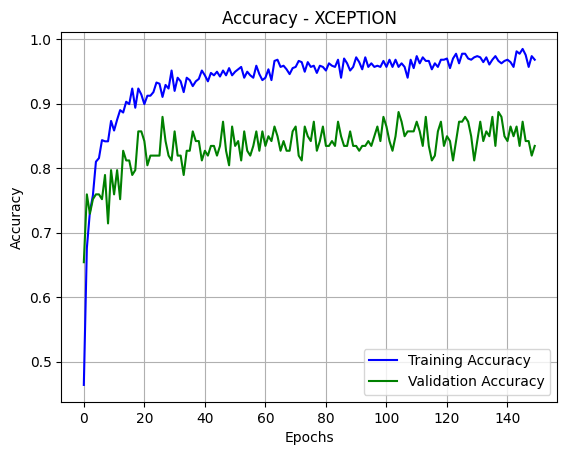

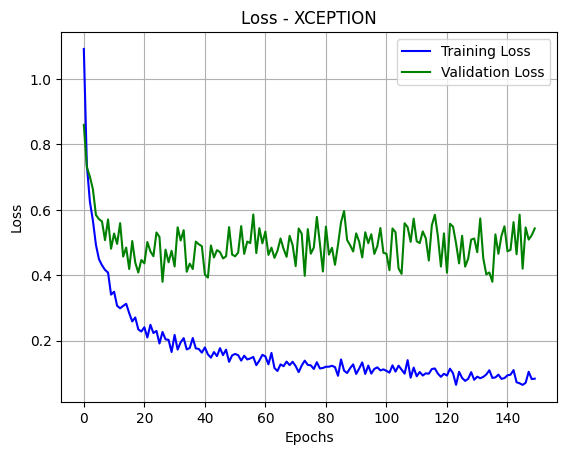

In [ ]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Accuracy - XCEPTION')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss per iteration
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Loss - XCEPTION')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#This code creates a line plot with the training F1 score represented by the blue line and the validation F1 score represented by the green line. The plot's title is set to "F1 Score - XCEPTION", and the x-axis is labeled as "Epochs". The y-axis represents the F1 score, and it is labeled accordingly.

#By using plt.legend(), a legend is added to the plot to differentiate between the training and validation F1 scores. The plt.grid(True) command adds a grid to the plot for better visualization.

#Finally, plt.show() is called to display the plot.

#This code allows you to visualize the trend and performance of the F1 score over the training epochs, providing insights into how the model's accuracy evolves during the training process.

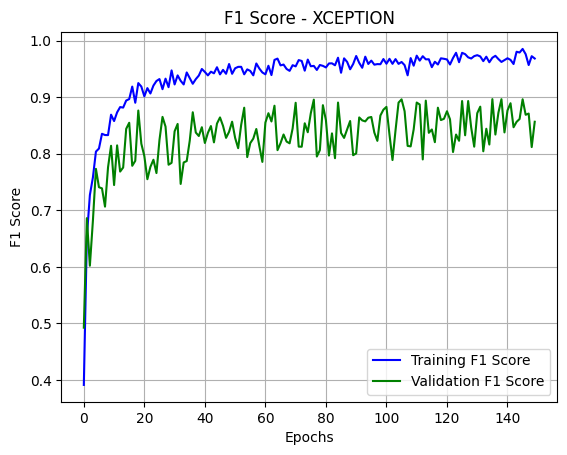

In [ ]:
# Plot F1 metric per iteration
plt.plot(history.history['f1_metric'], label='Training F1 Score', color='blue')
plt.plot(history.history['val_f1_metric'], label='Validation F1 Score', color='green')
plt.title('F1 Score - XCEPTION')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


# The model is used to make predictions on the test data using the predict_generator method and the resulting predictions are passed to the con_matrix function along with the true labels to plot the confusion matrix.

In [ ]:
from keras.models import load_model
from keras import layers

Y_pred=[]
Y_act=[]
i=0
for x,y in test_generator:
  i+=1
  print(i)
  Y_pred=Y_pred+list(np.argmax(model_final.predict(x),axis=1))
  Y_act=Y_act+list(np.argmax(y,axis=1))
  if i==10:
    break

1
1/1 [==============================] - 3s 3s/step
2
1/1 [==============================] - 2s 2s/step
3
1/1 [==============================] - 2s 2s/step
4
1/1 [==============================] - 1s 1s/step
5
1/1 [==============================] - 1s 1s/step
6
1/1 [==============================] - 2s 2s/step
7
1/1 [==============================] - 1s 1s/step
8
1/1 [==============================] - 1s 1s/step
9
1/1 [==============================] - 1s 1s/step
10
1/1 [==============================] - 0s 229ms/step


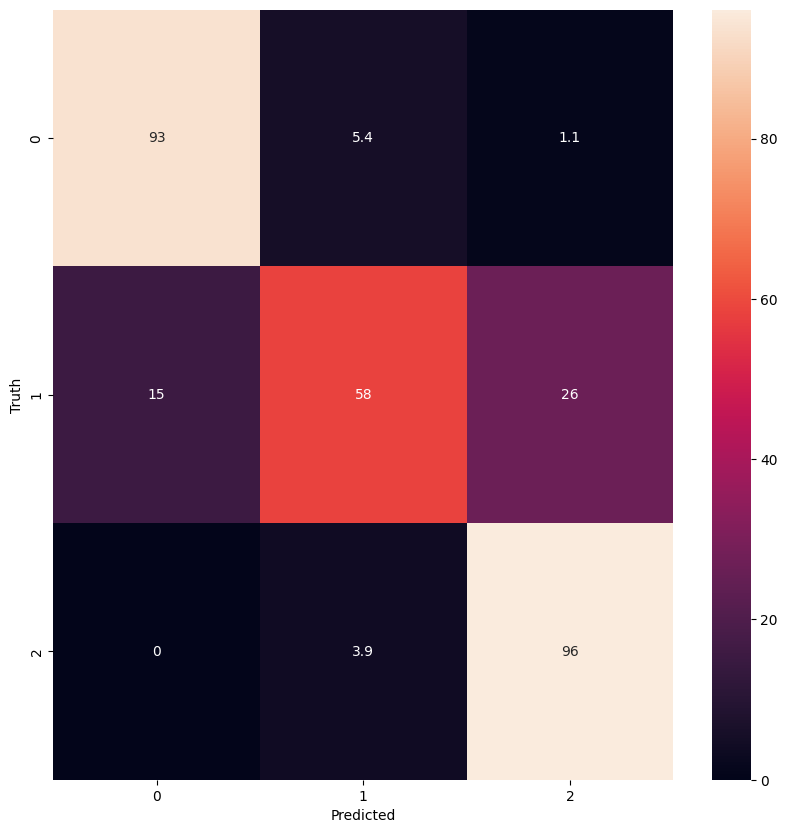

In [ ]:
Y_pred=np.array(Y_pred).flatten()
Y_act=np.array(Y_act).flatten()


con_matrix(Y_act,Y_pred)

In [ ]:
from keras.models import load_model
from keras import layers
model = load_model('/content/drive/MyDrive/colab2best.h5');
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

# This code is creating a list of the outputs of the first 100 layers of a trained model, except for the Input layer. The layer_outputs list is created using a list comprehension that iterates over the layers of the model and appends the output of each layer to the list.

# The code then loads an image from the specified file and preprocesses it by resizing it to the desired size and normalizing the pixel values.

# A new model is then created using the original model's input and the outputs of the first 100 layers. This model is called the "activation model" because it is used to obtain the activations (i.e., output values) of the layers for a given input. The activation model is created using the Model function from the tf.keras.Model class and the inputs and outputs arguments are set to the original model's input and the layer_outputs list, respectively.

# The activation model is then used to predict the activations of the first 100 layers for the preprocessed image using the predict method. The resulting activations are stored in the activations variable.

# The layer_names list is a list of strings containing the names of the layers whose activations we want to visualize. The activ_list list is a list of the activations of the layers in the layer_names list.

In [ ]:
# Taking the outputs of first 100 layers from trained model, leaving the first Input layer, in a list
import keras
import tensorflow as tf
layer_outputs = [layer.output for layer in model.layers[1:100]]


test_image ="/content/drive/MyDrive/colab2/ripe/Ripe palm (1).jpg"


img = keras.utils.load_img(test_image, target_size=(128, 128))
img_arr = keras.utils.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.

# Defining a new model using original model's input and all the 100 layers outputs and then predicting the values for all those 100 layers for our test image.
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# These are names of layers, the outputs of which we are going to visualize.
layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]

1/1 [==============================] - 3s 3s/step


# This code is using the matplotlib library to plot 30 images of the activations of the first layer of the model. The plt.figure function is used to create a figure object with a specified size, and the fig.add_subplot function is used to add a subplot to the figure. The plt.imshow function is then used to plot the activations as an image using a color map specified by the cmap argument. The plt.xticks and plt.yticks functions are used to hide the x-axis and y-axis tick labels, respectively. The fig.subplots_adjust function is used to adjust the spacing between subplots.

# The activations of the first layer are stored in the activations[0] variable and are accessed using the index [0,:,:,img], where img ranges from 0 to 29. This indexing is used to select a single channel (i.e., a 2D image) from the activations of the first layer, which has a shape of (batch_size, height, width, channels). The plt.imshow function is then used to plot the selected channel as an image.

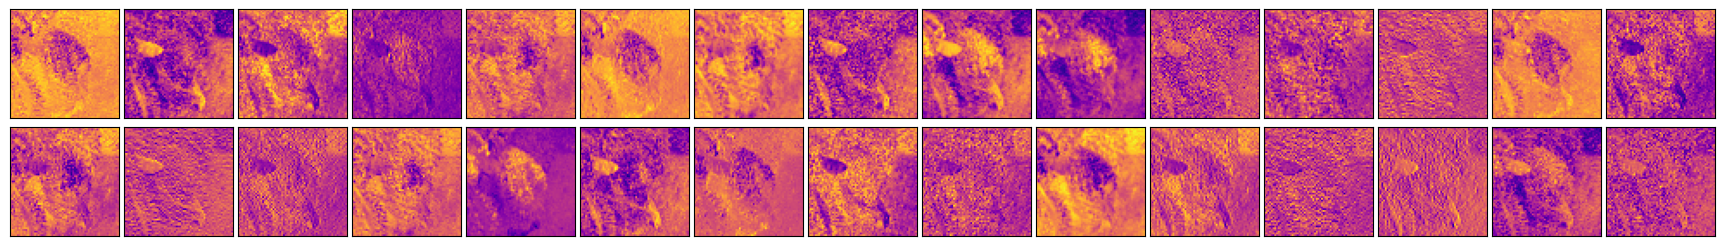

In [ ]:
fig = plt.figure(figsize=(22, 3))
for img in range(30):
    ax = fig.add_subplot(2, 15, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

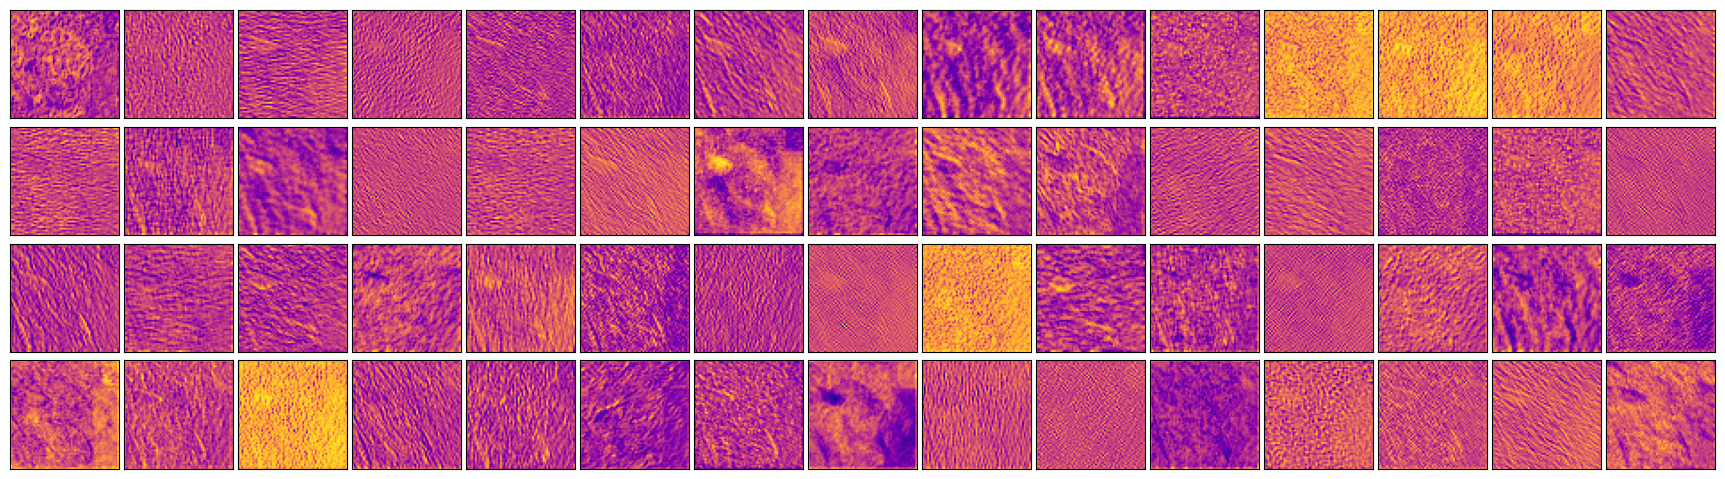

In [ ]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[10][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

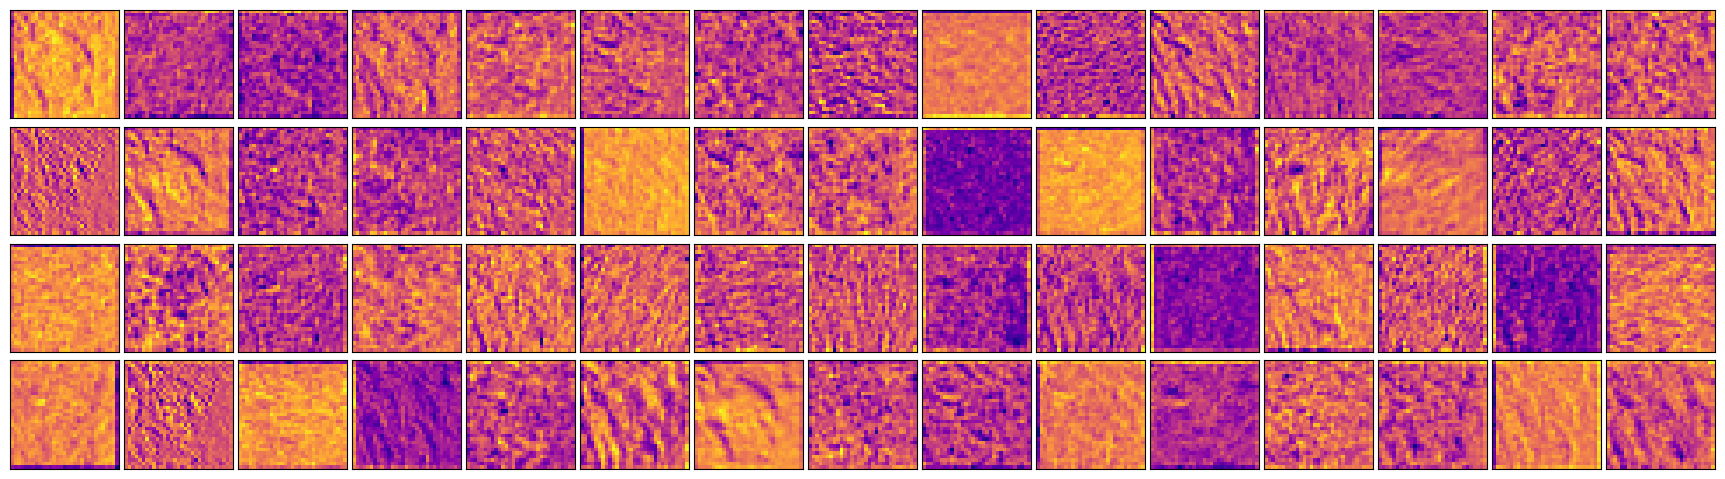

In [ ]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[17][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

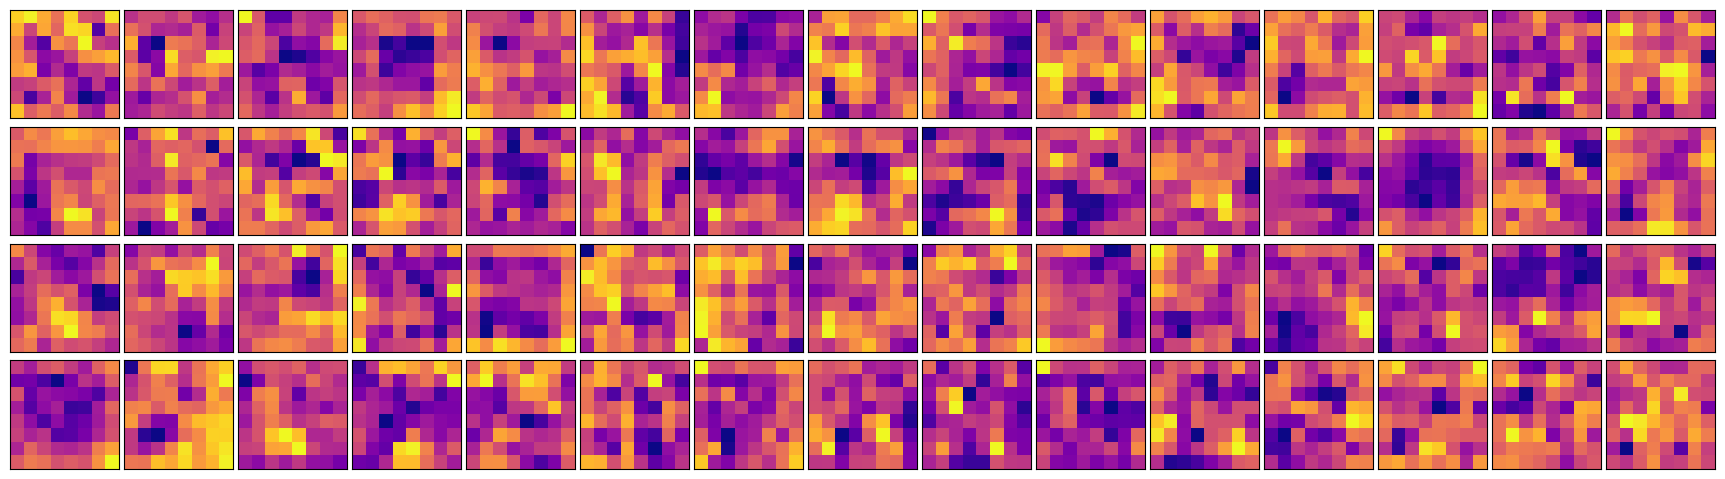

In [ ]:
# Activation maps from first Concatenate layer Mixed0, which concatenates the ReLU activated outputs from four convolution layers.
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[39][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

# __init__: Initializes the instance variables model, classIdx, and layerName with the specified values.

# find_target_layer: Finds the final convolutional layer in the model by looping over the layers of the model in reverse order and returning the first layer with a 4D output.

# compute_heatmap: Computes the class activation map (i.e., heatmap) for the input image using the selected layer of the model. This is done by creating a gradient model that takes the input image and predicts the activations of the selected layer and the predicted class scores for the input image. The gradient of the class score with respect to the activations is then computed using automatic differentiation, and the guided gradients are computed by applying a gradient mask to the gradients. The guided gradients are then used to compute the weights for the filters in the selected layer, which are used to compute the class activation map. The class activation map is then resized to match the size of the input image and normalized to lie in the range [0, 255].

# overlay_heatmap: Overlays the heatmap on the input image using a specified alpha value and color map.

# output_heatmap: Saves the heatmap and the overlaid image to file.

In [ ]:
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = 1
        self.layerName = "block14_sepconv2_act"
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

# The codes below will get the output

In [ ]:
img_path = "/content/drive/MyDrive/colab2/ripe/Ripe palm (1).jpg"

img = keras.utils.load_img(img_path, target_size=(128, 128))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x =np.array(x)/255
preds = model.predict(x)
print(preds)

1/1 [==============================] - 2s 2s/step
[[9.9930406e-01 6.0663273e-04 8.9317873e-05]]


In [ ]:
image = cv2.imread("/content/drive/MyDrive/colab2/ripe/Ripe palm (1).jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = model.predict(x)


print(preds)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 178ms/step
[[9.9930406e-01 6.0663273e-04 8.9317873e-05]]


In [ ]:
icam = GradCAM(model, i, 'block14_sepconv2_act')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (128, 128))

image1 = cv2.imread('/content/drive/MyDrive/colab2/ripe/Ripe palm (1).jpg')
image = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (128, 128))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(128, 128) (128, 128, 3)


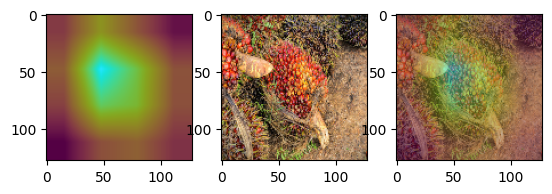

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

#***GUI***

#This command will install the Gradio library, which allows you to create interactive interfaces for your machine learning models.

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

#The code you provided imports several libraries including Gradio, Matplotlib, Numpy, OS, PIL, and TensorFlow. It also imports various modules and functions from the TensorFlow and Keras libraries.

#The f1_metric function is registered as a custom object in the Keras utils.get_custom_objects() dictionary, allowing it to be used as a metric in the loaded model.

#The model is loaded using the load_model function from Keras, and the path to the model file ('/content/drive/MyDrive/colab2best.h5') indicates the location of the saved model file that is being loaded.

#By loading the model, you can now use it for making predictions or further analysis.






In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import load_model
from keras import layers
keras.utils.get_custom_objects()['f1_metric'] = f1_metric
model = load_model('/content/drive/MyDrive/colab2best.h5');

ModuleNotFoundError: No module named 'gradio'

#By accessing the class_indices attribute of the train_generator, the code retrieves a dictionary that maps class names to their corresponding numeric labels. Using the keys() method, the code converts the dictionary keys (class names) into a list, which is then stored in the class_names variable.

#Finally, the class_names list is printed, displaying the names of the classes in your dataset. This can be useful for understanding the mapping between numeric labels and their corresponding class names, which is important when interpreting model predictions or evaluating classification results.

In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['ripe', 'underripe', 'unripe']


#Inside the function, the input image (img) is reshaped into a 4-dimensional array (img_4d) using the reshape function. This reshaping ensures that the image has the required dimensions for input to the model.

#Next, the reshaped image (img_4d) is passed to the loaded model using the predict function. The predict function generates predictions for the given input and returns the predicted probabilities for each class.

#The predicted probabilities (prediction) are then used to construct a dictionary comprehension that maps each class name (class_names[i]) to its corresponding predicted probability (float(prediction[i])).

#Finally, the dictionary containing the class probabilities is returned as the output of the predict_image function.

#This function can be used to make predictions on individual images by providing the image as input and obtaining the predicted probabilities for each class.






In [ ]:
def predict_image(img):
    img_4d = img.reshape(-1, 128, 128, 3)
    prediction = model.predict(img_4d)[0]
    return {class_names[i]: float(prediction[i]) for i in range(len(prediction))}

#The code defines an input component using gr.inputs.Image with a shape of (128, 128) to match the expected image size. The output component is defined as gr.outputs.Label with num_top_classes=4, indicating that it will display the top four predicted classes with their probabilities.

#Customizations are made to the interface by setting the name, title, description, theme, and layout variables to personalize the interface's appearance and information.

#The interface is created using gr.Interface, with the predict_image function as the input function, the image input component, and the label output component. Additional parameters like title, description, theme, and layout are passed to further customize the interface.

#Finally, the launch method is called on the interface to start the interface's server, and debug=True is set to enable debug mode.

#By running this code, the Gradio interface will be launched, allowing users to upload an image and obtain the predicted classes and their probabilities based on the predict_image function.

In [ ]:
image = gr.inputs.Image(shape=(128,128))
label = gr.outputs.Label(num_top_classes=4)

# Customize the interface
name = "Mohammed Hashem Mohammed Al-Kuhali"
title = f"Palm Fruit Ripeness Classification - {name}"
description = "Upload an image to classify"
theme = "huggingface"
layout = "vertical"

# Create and launch the interface
interface = gr.Interface(fn=predict_image, inputs=image, outputs=label, title=title, description=description, theme=theme, layout=layout)
interface.launch(debug=True)

<ipython-input-12-055201f8891e>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(128,128))
<ipython-input-12-055201f8891e>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(128,128))
<ipython-input-12-055201f8891e>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=4)
<ipython-input-12-055201f8891e>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=4)
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:697: UserWarning: Cannot load huggingface. Caught Exception: The space huggingface does not exist
  warnings.warn(f"Cann

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


#This is another GUIcode that uses the webcam as iruin webcam which is a phone camera


In [ ]:
image = gr.inputs.Image(shape=(128, 128), source="webcam")
label = gr.outputs.Label(num_top_classes=4)

# Customize the interface
name = "Mohammed Hashem Mohammed Al-Kuhali"
title = f"Palm Fruit Ripeness Classification - {name}"
description = "Use the camera to capture an image and classify it"
theme = "default"  # Customize the theme here
layout = "vertical"  # Customize the layout here

# Create and launch the interface
interface = gr.Interface(fn=predict_image, inputs=image, outputs=label, title=title, description=description, theme=theme, layout=layout)
interface.launch(debug=True, share=True)

AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
import gradio as gr

In [ ]:
!pip install gradio

  Using cached gradio-5.7.1-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
